In [52]:
import seaborn as sns
import os
import shutil
from pdockq import *
import json
import matplotlib.pyplot as plt

In [53]:
colors_sns = sns.color_palette('colorblind')
colors_sns

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [54]:
def get_pdockq(fn_pdb, fn_plddt):
    chain_coords = read_pdb(fn_pdb)
    #Check chains
    if len(chain_coords.keys())<2:
        print('Only one chain in pdbfile', args.pdbfile[0])

    #Get plDDT
    dict_scores = json.load(open(fn_plddt,'r'))
    plddt = np.array(dict_scores['plddt'])

    #Calculate pdockq
    t=8 #Distance threshold, set to 8 Å
    pdockq, ppv = calc_pdockq(chain_coords, plddt, t)
#     print('pDockQ =',np.round(pdockq,3),'for',fn_pdb.split('/')[-1])
#     print('This corresponds to a PPV of at least', ppv)
    return np.round(pdockq,3), ppv


In [55]:
def get_pdb_plddt_files(path_data):
    list_dir = [os.path.join(path_data, dir_temp) for dir_temp in os.listdir(path_data)]
    list_fn_pdb = [os.path.join(dir_temp, fn) for dir_temp in list_dir for fn in os.listdir(dir_temp) if '.pdb' in fn and 'rank_1' in fn]
    list_fn_plddt = [os.path.join(dir_temp, fn) for dir_temp in list_dir for fn in os.listdir(dir_temp) if '.json' in fn and 'rank_1' in fn]
    return list_fn_pdb, list_fn_plddt

In [56]:
def get_scores(list_fn_pdb, list_fn_plddt, first_alpha=False):
    list_pdockq = []
    list_ppv = []
    list_entry_pair = []
    
    for i in range(len(list_fn_pdb)):
        
        fn_pdb = list_fn_pdb[i]
        fn_plddt = list_fn_plddt[i]
        fn_only = fn_pdb.split('/')[-1]
        if first_alpha==False:
            if 'MSMEG' in fn_only and 'Rv' in fn_only:
                entry_pair = '_'.join(fn_only.split('_')[:4])
            elif 'MSMEG' in fn_only and not 'Rv' in fn_only:
                entry_pair = '_'.join(fn_only.split('_')[:5])
            else:
                entry_pair = '_'.join(fn_only.split('_')[:3])
        
        else:
            if 'MSMEG' in fn_only:
                entry_pair = '_'.join(fn_only.split('_')[1:6])              
            else:
                entry_pair = '_'.join(fn_only.split('_')[1:4])
            
            
        pdockq, ppv = get_pdockq(fn_pdb, fn_plddt)
        list_pdockq.append(pdockq)
        list_ppv.append(ppv)
        list_entry_pair.append(entry_pair)
    
    df_scores = pd.DataFrame()
    df_scores['Entry_pairs'] = list_entry_pair
    df_scores['pdockq'] = list_pdockq
    df_scores['ppv'] = list_ppv
    df_scores.sort_values(by = 'pdockq', ascending=False, inplace=True)
    df_scores.reset_index(inplace=True, drop=True)
    return df_scores

# Get scores for protein pair candidates:

List of test pairs from TnSeq correlations: 

In [57]:
path_tests = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq_v2/AF_pairs/AF2_complexes/'
list_fn_pdb, list_fn_plddt = get_pdb_plddt_files(path_tests)
df_tests = get_scores(list_fn_pdb, list_fn_plddt)
df_tests.shape

(85, 3)

List of randomized control of protein pairs:


In [58]:
path_GLS_rand = '/home/ajinich/Dropbox/KyuRhee/misc_code/saurabh/data/AF_complex_downloads_batch/random_v2/'
list_fn_pdb, list_fn_plddt = get_pdb_plddt_files(path_GLS_rand)
df_GLS_rand = get_scores(list_fn_pdb, list_fn_plddt)

Positive controls: 

In [ ]:
# Optional

## Plotting pDockQ scores: 

In [59]:
w_param = 0.3
x_val = 1
x_rand = [x_val + w_param*(np.random.uniform() - 0.5) for i in range(df_GLS_rand.shape[0])]
x_val = 2
x_tests = [x_val + w_param*(np.random.uniform() - 0.5) for i in range(df_tests.shape[0])] 

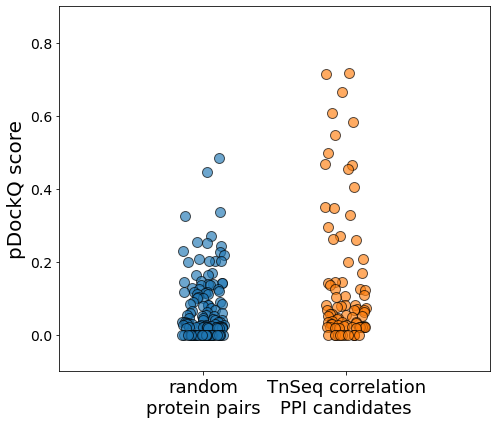

In [60]:
plt.figure(figsize = (7,6) )

plt.scatter(x_rand, df_GLS_rand.pdockq.values, s = 100, edgecolors='k', alpha = 0.65)
plt.scatter(x_tests, df_tests.pdockq.values, s = 100, edgecolors='k', alpha = 0.65)

plt.xlim(0, 3)
plt.ylim(-0.1, 0.9)
plt.yticks(fontsize = 14)
plt.xticks([1, 2], ['random\nprotein pairs', 'TnSeq correlation\nPPI candidates'], rotation=0, fontsize=18)
# plt.xticks([1, 2], ['big-small\nrandom\npairs', ''], rotation=0, fontsize=18)

plt.ylabel('pDockQ score', fontsize = 20)

plt.tight_layout()

path_fig = '../figures/AF2_complex/pdockq_comparison_092122.png'
plt.savefig(path_fig, dpi = 300)

Who are the top scoring pairs?: 

In [61]:
th_pdockq = df_GLS_rand.pdockq.max()
print(th_pdockq)
df_tests[df_tests.pdockq>th_pdockq]

0.485


,Entry_pairs,pdockq,ppv
0,Rv0170_and_Rv0173,0.718,0.981280
1,Rv1823_and_Rv1825,0.714,0.981280
2,Rv1765c_and_Rv2015c,0.664,0.981280
3,Rv2936_and_Rv2937,0.608,0.940019
4,Rv2936_and_Rv2938,0.583,0.924203
5,Rv3279c_and_Rv3281,0.548,0.916299
6,Rv1037c_and_Rv3619c,0.499,0.900431


# Clean up folders from large files: 

In [62]:
mother_dir = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq_v2/AF_pairs/AF2_complexes/'

# traverse root directory, and list directories as dirs and files as files
list_fn_a3m = []
for root, dirs, files in os.walk(mother_dir):
    path = root.split(os.sep)
    for file in files:
        if ".a3m" in file:
            list_fn_a3m.append(os.path.join(root, file))

In [63]:
for fn in list_fn_a3m:
    os.remove(fn)

#### Remove from "pending" to "done" directories

In [64]:
source_dir = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq_v2/AF_pairs/PENDING/' # this is where the pending fasta files are. 
target_dir = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq_v2/AF_pairs/DONE/' # this is where the processed fasta files are moved
results_dir = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq_v2/AF_pairs/AF2_complexes/' # this is where the AF2 results are kept

list_source_fn = [fn.split('.')[0] for fn in os.listdir(source_dir)]
list_result_dir = [d.split('.')[0] for d in os.listdir(results_dir)]

list_to_move_src = [os.path.join(source_dir, fn+'.fasta') for fn in list_source_fn if fn in list_result_dir]
list_to_move_target = [os.path.join(target_dir, fn+'.fasta') for fn in list_source_fn if fn in list_result_dir]

len(list_to_move_target)

40

In [65]:
for i in range(len(list_to_move_src)):
    shutil.move( list_to_move_src[i], list_to_move_target[i] )